In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.utils.data as dataloader

In [2]:
batch_size = 64
img_size = 28
patch_size = 7
num_channels = 1
num_patches = (img_size // patch_size) ** 2

embed_dim = 16
mlp_dim = 16

mlp_nodes = 64

num_classes = 10

transformer_blocks = 4
attention_heads = 4

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [4]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
valset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.91MB/s]


In [5]:
train_data = dataloader.DataLoader(trainset,shuffle=True,batch_size=batch_size)
val_data = dataloader.DataLoader(valset,shuffle=True,batch_size=batch_size)

In [6]:
#Part1 of Vision Transformer Architecture

class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self, x):
      return self.patch_embed(x).flatten(2).transpose(1,2)

In [7]:
images,labels = next(iter(train_data))
images.shape

torch.Size([64, 1, 28, 28])

In [8]:
PatchEmbed = PatchEmbedding()

PatchEmbed.forward(images).shape

torch.Size([64, 16, 16])

In [9]:
#TransformerArchitecture of ViT
class TransformerArchitecture(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.self_attention = nn.MultiheadAttention(embed_dim,num_heads=attention_heads,dropout=0.2,batch_first=True)
    self.layernorm2 = nn.LayerNorm(embed_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim,mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim,embed_dim)
    )

  def forward(self,x):
    residual1 = x
    x = self.self_attention(self.layernorm1(x),self.layernorm1(x),self.layernorm1(x))[0] + residual1
    residual2 = x
    x = self.mlp(self.layernorm2(x)) + residual2
    return x

In [10]:
class MLP_Head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(embed_dim)
    self.mlphead = nn.Sequential(
        #nn.Linear(embed_dim),
        nn.Linear(embed_dim,num_classes)
    )

  def forward(self,x):
    x = x[:,0] # only cls(classification token)
    x = self.layernorm1(x)
    x = self.mlphead(x)
    return x

In [15]:
class ViT(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.position_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerArchitecture()for _ in  range(transformer_blocks)])
    self.mlphead = MLP_Head()

  def forward(self,x):
    x = self.patch_embedding(x)
    B = x.shape[0]
    cls_tokens = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)
    x = self.mlphead(x)
    return x


In [16]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

model = ViT()
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

epochs = 5

In [17]:
for epoch in range(epochs):
  model.to(device)
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"\nEpoch {epoch+1}")
  for batch_idx,(images,labels) in enumerate(train_data):
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()
    pred = model(images)

    loss = loss_func(pred,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    preds = pred.argmax(dim=1)

    correct = (preds==labels).sum().item()
    accuracy = 100*correct/labels.size(0)

    correct_epoch+=correct
    total_epoch+=labels.size(0)

    if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

  epoch_acc = 100.0 * correct_epoch / total_epoch
  print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")






Epoch 1
  Batch   1: Loss = 2.6598, Accuracy = 9.38%
  Batch 101: Loss = 2.1420, Accuracy = 37.50%
  Batch 201: Loss = 1.0989, Accuracy = 57.81%
  Batch 301: Loss = 0.8072, Accuracy = 75.00%
  Batch 401: Loss = 0.7455, Accuracy = 76.56%
  Batch 501: Loss = 0.4745, Accuracy = 90.62%
  Batch 601: Loss = 0.3835, Accuracy = 89.06%
  Batch 701: Loss = 0.4381, Accuracy = 87.50%
  Batch 801: Loss = 0.6100, Accuracy = 78.12%
  Batch 901: Loss = 0.2092, Accuracy = 95.31%
==> Epoch 1 Summary: Total Loss = 821.2191, Accuracy = 72.11%

Epoch 2
  Batch   1: Loss = 0.4814, Accuracy = 85.94%
  Batch 101: Loss = 0.3426, Accuracy = 90.62%
  Batch 201: Loss = 0.4636, Accuracy = 82.81%
  Batch 301: Loss = 0.1362, Accuracy = 96.88%
  Batch 401: Loss = 0.4963, Accuracy = 82.81%
  Batch 501: Loss = 0.2438, Accuracy = 92.19%
  Batch 601: Loss = 0.4423, Accuracy = 84.38%
  Batch 701: Loss = 0.3008, Accuracy = 90.62%
  Batch 801: Loss = 0.4404, Accuracy = 87.50%
  Batch 901: Loss = 0.2989, Accuracy = 92.19%
=

In [18]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 95.48%


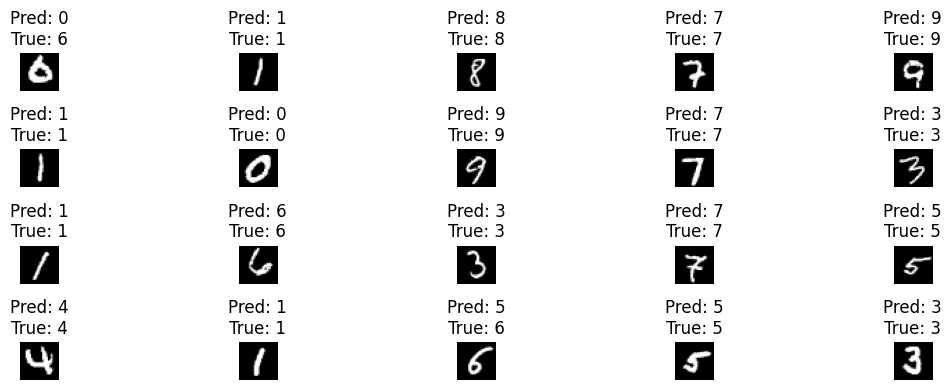

In [21]:
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().cpu(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()